In [ ]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import tqdm

import gym

## Cliff Walking environment

https://www.gymlibrary.dev/environments/toy_text/cliff_walking/

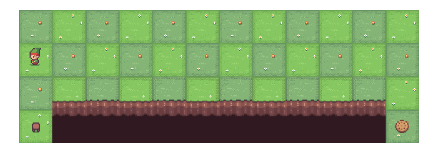

The board is a 4x12 matrix, with (using NumPy matrix indexing):
- [3, 0] as the start at bottom-left
- [3, 11] as the goal at bottom-right
- [3, 1..10] as the cliff at bottom-center

If the agent steps on the cliff, it returns to the start (it does not terminate the episode). An episode terminates when the agent reaches the goal.

There are 4 discrete deterministic actions:
- 0: move up
- 1: move right
- 2: move down
- 3: move left



In [67]:
env = gym.make("CliffWalking-v0")

In [ ]:
P = env.P
# for each state s, P[s] is a dictionary with each of the 4 actions as keys
# for each of 4 actions, the value is a tuple (prob, next_state, reward, done)
print(P[0])

{0: [(1.0, 0, -1, False)], 1: [(1.0, 1, -1, False)], 2: [(1.0, 12, -1, False)], 3: [(1.0, 0, -1, False)]}


In [ ]:
env.reset()

(36, {'prob': 1})

In [ ]:
env.step(0)

(24, -1, False, False, {'prob': 1.0})

## SARSA

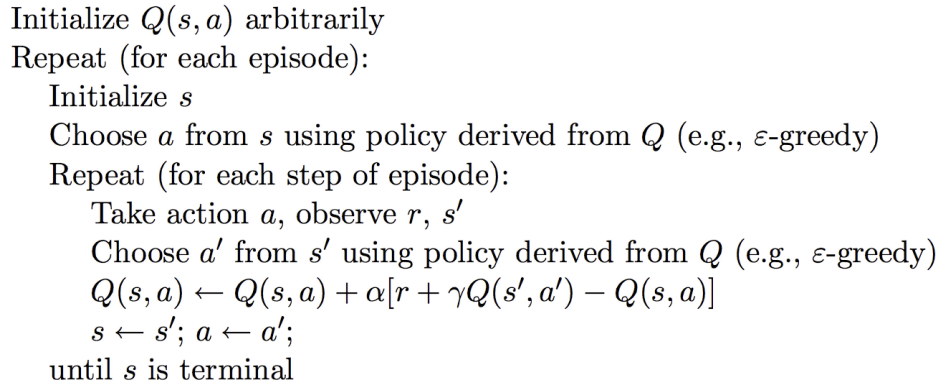

In [ ]:
def SARSA(alpha, gamma, epsilon, num_episodes, epsilon_decay=0):

  # initialize Q-table with zeros
  Q = np.zeros((env.observation_space.n, env.action_space.n))
  reward_per_episode = []

  # SARSA algorithm
  for episode in range(num_episodes):

      # initialise s
      state = env.reset()[0]

      # choose action a from state s using e-greedy
      action = np.argmax(Q[state,:])
      if np.random.rand() < epsilon: 
        action = env.action_space.sample()

      done = False
      total_reward = 0
      # perform each step of the episode
      while not done:
          # take action a
          new_state, reward, done, _, _ = env.step(action)

          # choose new action a' from new state s' using e-greedy
          new_action = np.argmax(Q[new_state,:]+np.random.normal(0,1e-8, size=env.action_space.n))
          if np.random.rand() < epsilon: 
            new_action = env.action_space.sample()

          # update Q-table and s, a
          Q[state, action] = Q[state, action] + alpha * (reward + gamma * Q[new_state, new_action] - Q[state, action])
          state = new_state
          action = new_action

          # accumulate total reward
          total_reward += reward

      if epsilon_decay:
         if episode%epsilon_decay==epsilon_decay-1: epsilon /= 10

      reward_per_episode.append(total_reward)

  return Q, reward_per_episode

## Q-learning

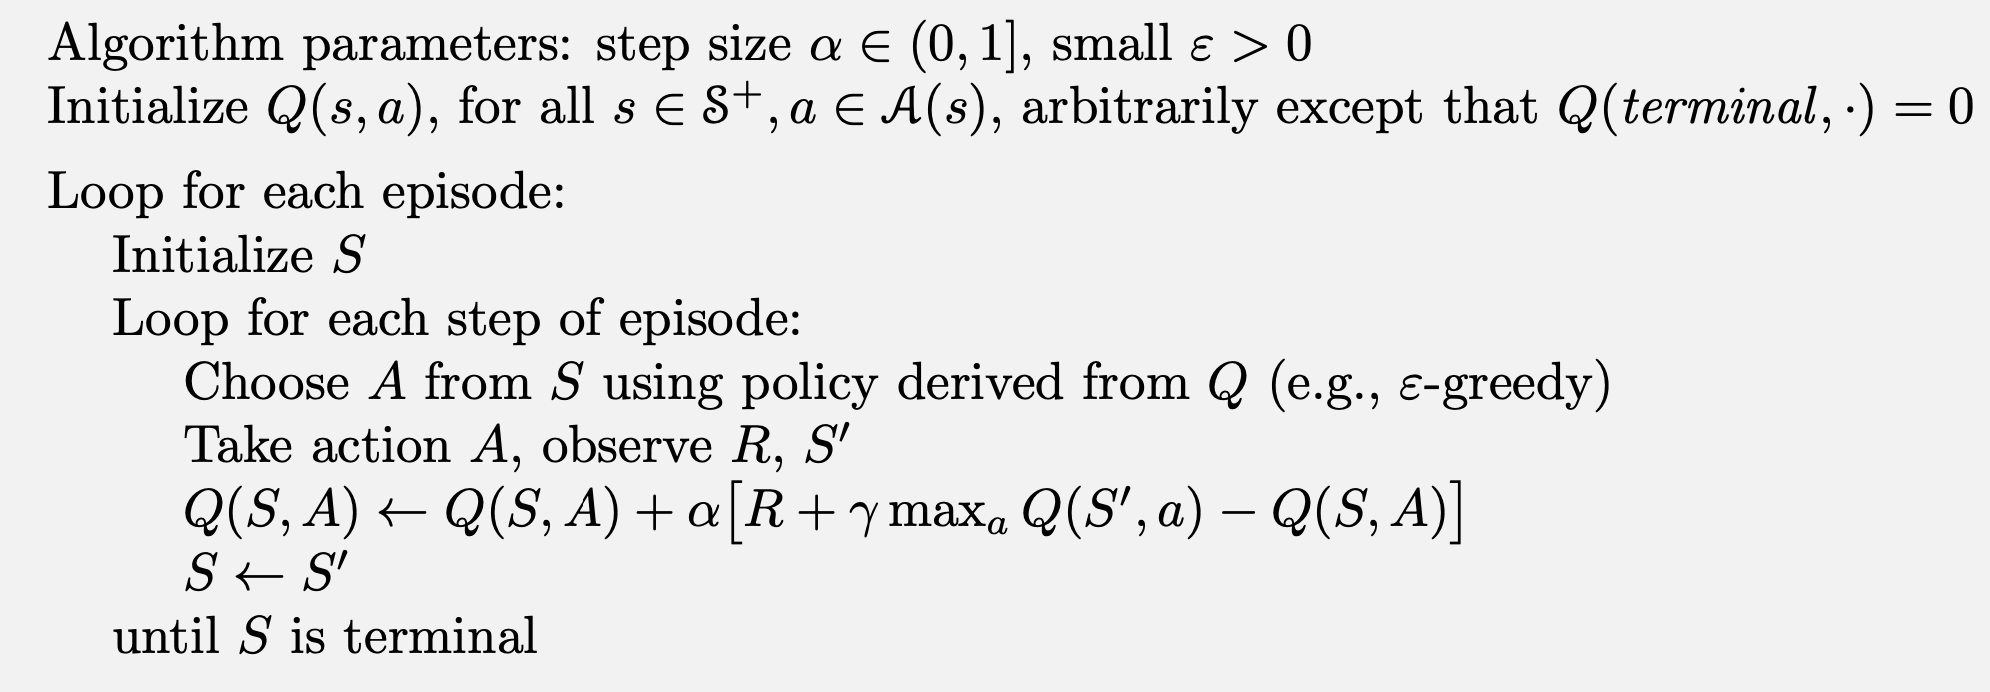

In [ ]:
def Q_learning(alpha, gamma, epsilon, num_episodes, epsilon_decay=0):

  # initialize Q-table arbitrarily
  Q = np.zeros((env.observation_space.n, env.action_space.n))
  reward_per_episode = []

  # Q-learning algorithm
  for episode in range(num_episodes):

      # initialise s
      state = env.reset()[0]

      done = False
      total_reward = 0
      # perform each step of the episode
      while not done:

          # choose new action a' from new state s' using e-greedy
          action = np.argmax(Q[state,:] + np.random.normal(0,1e-8, size=env.action_space.n))
          if np.random.rand() < epsilon: 
            action = env.action_space.sample()

          # take action a
          new_state, reward, done, _, _  = env.step(action)

          # update Q-table and s, a
          Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])
          state = new_state

          # accumulate total reward
          total_reward += reward

      if epsilon_decay:
         if episode%epsilon_decay==epsilon_decay-1: epsilon /= 10

      reward_per_episode.append(total_reward)

  return Q, reward_per_episode

## Expected SARSA

The same as Q-Learning, except that the update is given by

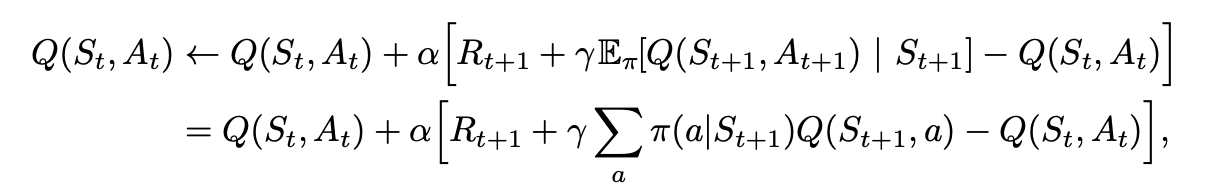

In [ ]:
def expected_SARSA(alpha, gamma, epsilon, num_episodes, epsilon_decay=0):

  # initialize Q-table arbitrarily
  Q = np.zeros((env.observation_space.n, env.action_space.n))
  reward_per_episode = []

  # Q-learning algorithm
  for episode in range(num_episodes):

      # initialise s
      state = env.reset()[0]

      done = False
      total_reward = 0
      # perform each step of the episode
      while not done:

          # choose new action a' from new state s' using e-greedy
          greedy_action = np.argmax(Q[state,:]+np.random.normal(0,1e-8, size=env.action_space.n))
          if np.random.rand() < epsilon: 
            action = env.action_space.sample()
          else:
            action = greedy_action

          # compute probabilities
          prob_actions = epsilon/env.action_space.n + np.zeros(env.action_space.n)
          prob_actions[greedy_action] += 1 - epsilon

          # take action a
          new_state, reward, done, _ , _ = env.step(action)

          # update Q-table and s, a
          Q[state, action] = Q[state, action] + alpha * (reward + gamma * (prob_actions @ Q[new_state, :]) - Q[state, action])
          state = new_state

          # accumulate total reward
          total_reward += reward

      if epsilon_decay:
         if episode%epsilon_decay==epsilon_decay-1: epsilon /= 10

      reward_per_episode.append(total_reward)

  return Q, reward_per_episode

## Double Q-learning

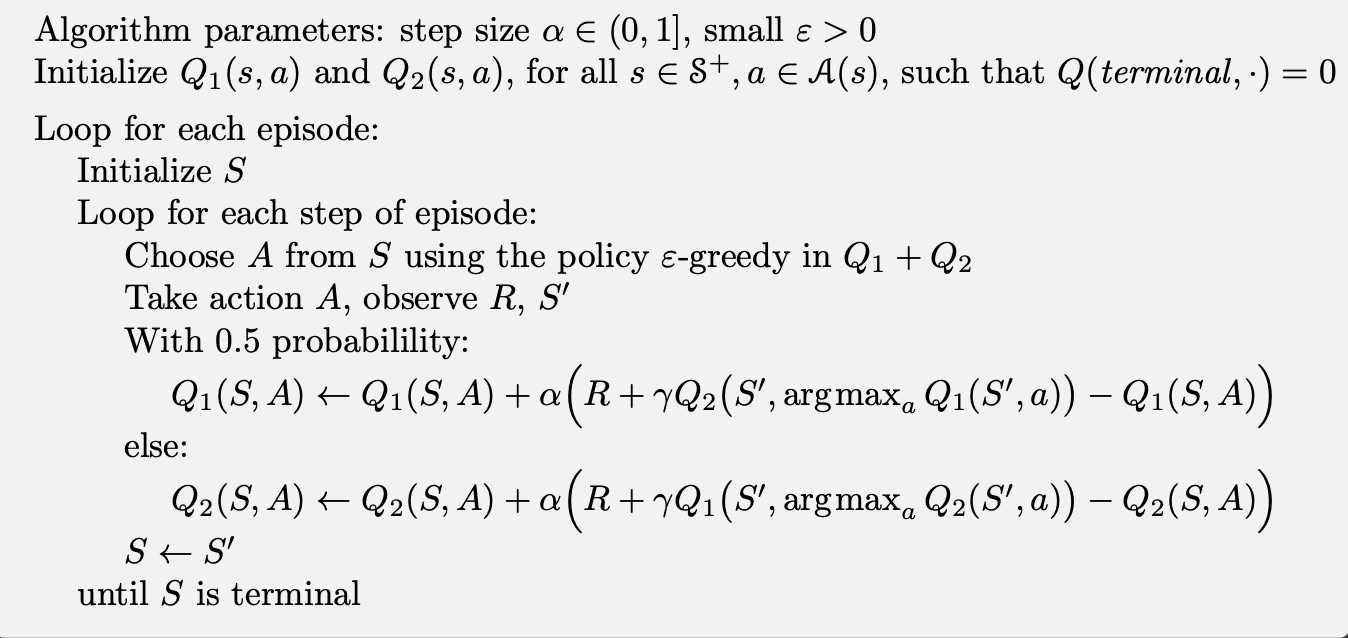

In [ ]:
def double_Q_learning(alpha, gamma, epsilon, num_episodes, epsilon_decay=0):
  # initialize Q-tables arbitrarily
  Q_1 = np.zeros((env.observation_space.n, env.action_space.n))
  Q_2 = np.zeros((env.observation_space.n, env.action_space.n))
  reward_per_episode = []

  # Double Q-learning algorithm
  for episode in range(num_episodes):

      # initialise s
      state = env.reset()[0]

      done = False
      total_reward = 0
      # perform each step of the episode
      while not done:

          # choose new action a' from new state s' using e-greedy
          action = np.argmax(Q_1[state,:] + Q_2[state,:] + np.random.normal(0,1e-8, size=env.action_space.n))
          if np.random.rand() < epsilon: 
            action = env.action_space.sample()

          # take action a
          new_state, reward, done, _, _ = env.step(action)

          # update Q-tables and s, a
          if np.random.rand() <= 0.5:
            Q_1[state, action] = Q_1[state, action] + alpha * (reward + gamma * Q_2[new_state, np.argmax(Q_1[new_state, :]+np.random.normal(0,1e-8, size=env.action_space.n))] - Q_1[state, action])
          else:
            Q_2[state, action] = Q_2[state, action] + alpha * (reward + gamma * Q_1[new_state, np.argmax(Q_2[new_state, :]+np.random.normal(0,1e-8, size=env.action_space.n))] - Q_2[state, action])

          state = new_state

          # accumulate total reward
          total_reward += reward

      if epsilon_decay:
         if episode%epsilon_decay==epsilon_decay-1: epsilon /= 10

      reward_per_episode.append(total_reward)

  return Q_1 + Q_2, reward_per_episode

## Comparison

In [68]:
# set hyperparameters
alpha = 0.2
gamma = 0.99
epsilon = 0.1
num_episodes = 1000
epsilon_decay = 200 # number of steps at which epsilon decays (/10)
n_runs = 50

# rewards per episode 
Q_learning_results = np.zeros((n_runs, num_episodes))
SARSA_results = np.zeros((n_runs, num_episodes))
expected_SARSA_results = np.zeros((n_runs, num_episodes))
double_Q_learning_results = np.zeros((n_runs, num_episodes))

# resulting Q-tables
Q_Q_learning = np.zeros((n_runs, env.observation_space.n, env.action_space.n))
Q_SARSA = np.zeros((n_runs, env.observation_space.n, env.action_space.n))
Q_expected_SARSA = np.zeros((n_runs, env.observation_space.n, env.action_space.n))
Q_double_Q_learning = np.zeros((n_runs, env.observation_space.n, env.action_space.n))


for run in tqdm.tqdm(range(n_runs)):
    Q_Q_learning[run, :], Q_learning_results[run,:] = Q_learning(alpha, gamma, epsilon, num_episodes, epsilon_decay=epsilon_decay)
    Q_SARSA[run, :], SARSA_results[run,:] = SARSA(alpha, gamma, epsilon, num_episodes, epsilon_decay=epsilon_decay)
    Q_expected_SARSA[run, :], expected_SARSA_results[run,:] = expected_SARSA(alpha, gamma, epsilon, num_episodes, epsilon_decay=epsilon_decay)
    Q_double_Q_learning[run, :], double_Q_learning_results[run,:] = double_Q_learning(alpha, gamma, epsilon, num_episodes, epsilon_decay=epsilon_decay)

100%|██████████| 50/50 [02:41<00:00,  3.23s/it]


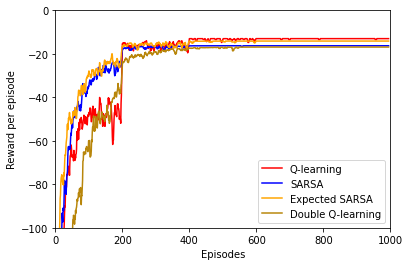

In [73]:
n = 5 # moving average parameter (for reduced noise)
plt.plot(np.convolve(Q_learning_results.mean(axis=0), np.ones(n), "valid")/n, label="Q-learning", c="red")
plt.plot(np.convolve(SARSA_results.mean(axis=0), np.ones(n), "valid")/n, label="SARSA", c="blue")
plt.plot(np.convolve(expected_SARSA_results.mean(axis=0), np.ones(n), "valid")/n, label="Expected SARSA", c="orange")
plt.plot(np.convolve(double_Q_learning_results.mean(axis=0), np.ones(n), "valid")/n, label="Double Q-learning", c="darkgoldenrod")
plt.xlabel("Episodes")
plt.ylabel("Reward per episode")
plt.ylim([-100,0])
plt.xlim([0,num_episodes])
plt.legend();

In [70]:
def greedification(q_value_function):
  policy = np.zeros(env.observation_space.n, dtype=int)

  for state in range(env.observation_space.n-1):
      policy[state] = np.argmax(q_value_function[state,:])

  optimal_path = [36]
  state = 36
  while state!=47:
    if policy[state] == 0: state -= 12
    elif policy[state] == 1: state += 1
    elif policy[state] == 2: state += 12
    elif policy[state] == 3: state -= 1
    optimal_path.append(state)
  
  policy[[x for x in np.arange(48) if x not in optimal_path]] = -1
  policy[np.arange(37,47)] = -2

  return policy

def print_policy(policy, title=None):
  mapping = {
      0: "\u2191",
      1: "\u2192",
      2: "\u2193",
      3: "\u2190",
      -1: "\u25A1",
      -2: "\u25A0"
  }
  arr = np.vectorize(mapping.get)(policy)
  arr[-1] = "🏁"
  if title: print(title)
  print(arr.reshape(4,12))
  print("")

In [71]:
print_policy(greedification(Q_Q_learning.mean(axis=0)), title="Q-learning")
print_policy(greedification(Q_SARSA.mean(axis=0)), title="SARSA")
print_policy(greedification(Q_expected_SARSA.mean(axis=0)), title="Expected SARSA")
print_policy(greedification(Q_double_Q_learning.mean(axis=0)), title="Double Q-learning")

Q-learning
[['□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□']
 ['□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' '■' '■' '■' '■' '■' '■' '■' '■' '■' '■' '🏁']]

SARSA
[['□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '↓']
 ['↑' '■' '■' '■' '■' '■' '■' '■' '■' '■' '■' '🏁']]

Expected SARSA
[['□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□']
 ['□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' '■' '■' '■' '■' '■' '■' '■' '■' '■' '■' '🏁']]

Double Q-learning
[['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '↓']
 ['↑' '□' '□' '□' '□' '□' '□' '□' '□' '□' '□' '↓']
 ['↑' '■' '■' '■' '■' '■' '■' '■' '■' '■' '■' '🏁']]



## Frozen Lake environment

https://www.gymlibrary.dev/environments/toy_text/frozen_lake/

The agent takes a 1-element vector for actions. The action space is (dir), where dir decides direction to move in which can be:

- 0: LEFT
- 1: DOWN
- 2: RIGHT
- 3: UP

Reward schedule:

- Reach goal(G): +1
- Reach hole(H): 0
- Reach frozen(F): 0

``is_slippery``: True/False. If True will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions.

For example, if action is left and is_slippery is True, then:
- P(move left)=1/3
- P(move up)=1/3
- P(move down)=1/3


### Small frozen lake (4x4) - slippery



In [ ]:
env = gym.make("FrozenLake-v1")

In [ ]:
# set hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 0.1
num_episodes = 10000
epsilon_decay = 2500 # number of steps at which epsilon decays (/10)
n_runs = 5

# rewards per episode 
Q_learning_results = np.zeros((n_runs, num_episodes))
SARSA_results = np.zeros((n_runs, num_episodes))
expected_SARSA_results = np.zeros((n_runs, num_episodes))
double_Q_learning_results = np.zeros((n_runs, num_episodes))

# resulting Q-tables
Q_Q_learning = np.zeros((n_runs, env.observation_space.n, env.action_space.n))
Q_SARSA = np.zeros((n_runs, env.observation_space.n, env.action_space.n))
Q_expected_SARSA = np.zeros((n_runs, env.observation_space.n, env.action_space.n))
Q_double_Q_learning = np.zeros((n_runs, env.observation_space.n, env.action_space.n))

for run in tqdm.tqdm(range(n_runs)):
    Q_Q_learning[run, :], Q_learning_results[run,:] = Q_learning(alpha, gamma, epsilon, num_episodes, epsilon_decay=epsilon_decay)
    Q_SARSA[run, :], SARSA_results[run,:] = SARSA(alpha, gamma, epsilon, num_episodes, epsilon_decay=epsilon_decay)
    Q_expected_SARSA[run, :], expected_SARSA_results[run,:] = expected_SARSA(alpha, gamma, epsilon, num_episodes, epsilon_decay=epsilon_decay)
    Q_double_Q_learning[run, :], double_Q_learning_results[run,:] = double_Q_learning(alpha, gamma, epsilon, num_episodes, epsilon_decay=epsilon_decay)

100%|██████████| 5/5 [04:09<00:00, 49.91s/it]


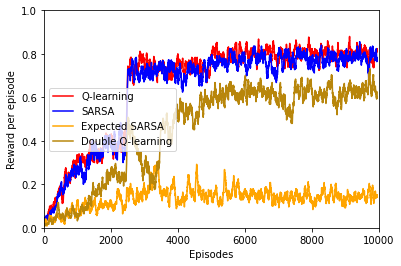

In [ ]:
n = 50 # moving average parameter
plt.plot(np.convolve(Q_learning_results.mean(axis=0), np.ones(n), "valid")/n, label="Q-learning", c="red")
plt.plot(np.convolve(SARSA_results.mean(axis=0), np.ones(n), "valid")/n, label="SARSA", c="blue")
plt.plot(np.convolve(expected_SARSA_results.mean(axis=0), np.ones(n), "valid")/n, label="Expected SARSA", c="orange")
plt.plot(np.convolve(double_Q_learning_results.mean(axis=0), np.ones(n), "valid")/n, label="Double Q-learning", c="darkgoldenrod")
plt.xlabel("Episodes")
plt.ylabel("Reward per episode")
plt.ylim([0,1])
plt.xlim([0,num_episodes])
plt.legend();

In [ ]:
def greedification(q_value_function):
  policy = np.zeros(env.observation_space.n, dtype=int)

  for state in range(env.observation_space.n-1):
      policy[state] = np.argmax(q_value_function[state,:])

  """
  optimal_path = [0]
  state = 0
  while state!=15:
    if policy[state] == 0: state -= 12
    elif policy[state] == 1: state += 1
    elif policy[state] == 2: state += 12
    elif policy[state] == 3: state -= 1
    optimal_path.append(state)
  """
  #policy[[x for x in np.arange(48) if x not in optimal_path]] = -1
  policy[[5,7,11,12]] = -2

  return policy

def print_policy(policy, title=None):
  mapping = {
      0: "\u2190",
      1: "\u2193",
      2: "\u2192",
      3: "\u2191",
      -1: "\u25A1",
      -2: "\u25A0"
  }
  arr = np.vectorize(mapping.get)(policy)
  arr[-1] = "🏁"
  if title: print(title)
  print(arr.reshape(4,4))
  print("")

In [ ]:
print_policy(greedification(Q_Q_learning.mean(axis=0)), title="Q-learning")
print_policy(greedification(Q_SARSA.mean(axis=0)), title="SARSA")
print_policy(greedification(Q_expected_SARSA.mean(axis=0)), title="Expected SARSA")
print_policy(greedification(Q_double_Q_learning.mean(axis=0)), title="Double Q-learning")

Q-learning
[['←' '↑' '←' '↑']
 ['←' '■' '←' '■']
 ['↑' '↓' '←' '■']
 ['■' '→' '↓' '🏁']]

SARSA
[['←' '↑' '←' '↑']
 ['←' '■' '→' '■']
 ['↑' '↓' '←' '■']
 ['■' '→' '↓' '🏁']]

Expected SARSA
[['←' '↑' '→' '↑']
 ['←' '■' '→' '■']
 ['↓' '↓' '↓' '■']
 ['■' '↓' '↓' '🏁']]

Double Q-learning
[['←' '↑' '←' '↓']
 ['←' '■' '→' '■']
 ['↑' '↓' '↓' '■']
 ['■' '→' '↓' '🏁']]



### Small frozen lake (4x4) - non-slippery

In [ ]:
env = gym.make("FrozenLake-v1", is_slippery=False)

In [ ]:
# set hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 0.1
num_episodes = 2000
epsilon_decay = 500 # number of steps at which epsilon decays (/10)
n_runs = 10

# rewards per episode 
Q_learning_results = np.zeros((n_runs, num_episodes))
SARSA_results = np.zeros((n_runs, num_episodes))
expected_SARSA_results = np.zeros((n_runs, num_episodes))
double_Q_learning_results = np.zeros((n_runs, num_episodes))

# resulting Q-tables
Q_Q_learning = np.zeros((n_runs, env.observation_space.n, env.action_space.n))
Q_SARSA = np.zeros((n_runs, env.observation_space.n, env.action_space.n))
Q_expected_SARSA = np.zeros((n_runs, env.observation_space.n, env.action_space.n))
Q_double_Q_learning = np.zeros((n_runs, env.observation_space.n, env.action_space.n))

for run in tqdm.tqdm(range(n_runs)):
    Q_Q_learning[run, :], Q_learning_results[run,:] = Q_learning(alpha, gamma, epsilon, num_episodes, epsilon_decay=epsilon_decay)
    Q_SARSA[run, :], SARSA_results[run,:] = SARSA(alpha, gamma, epsilon, num_episodes, epsilon_decay=epsilon_decay)
    Q_expected_SARSA[run, :], expected_SARSA_results[run,:] = expected_SARSA(alpha, gamma, epsilon, num_episodes, epsilon_decay=epsilon_decay)
    Q_double_Q_learning[run, :], double_Q_learning_results[run,:] = double_Q_learning(alpha, gamma, epsilon, num_episodes, epsilon_decay=epsilon_decay)

100%|██████████| 10/10 [00:31<00:00,  3.19s/it]


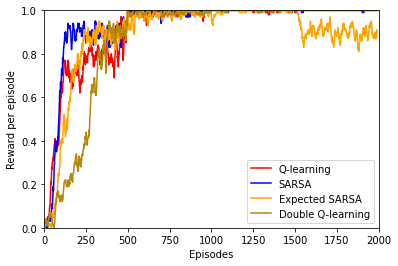

In [ ]:
n = 10 # moving average parameter
plt.plot(np.convolve(Q_learning_results.mean(axis=0), np.ones(n), "valid")/n, label="Q-learning", c="red")
plt.plot(np.convolve(SARSA_results.mean(axis=0), np.ones(n), "valid")/n, label="SARSA", c="blue")
plt.plot(np.convolve(expected_SARSA_results.mean(axis=0), np.ones(n), "valid")/n, label="Expected SARSA", c="orange")
plt.plot(np.convolve(double_Q_learning_results.mean(axis=0), np.ones(n), "valid")/n, label="Double Q-learning", c="darkgoldenrod")
plt.xlabel("Episodes")
plt.ylabel("Reward per episode")
plt.ylim([0,1])
plt.xlim([0,num_episodes])
plt.legend();

In [ ]:
print_policy(greedification(Q_Q_learning.mean(axis=0)), title="Q-learning")
print_policy(greedification(Q_SARSA.mean(axis=0)), title="SARSA")
print_policy(greedification(Q_expected_SARSA.mean(axis=0)), title="Expected SARSA")
print_policy(greedification(Q_double_Q_learning.mean(axis=0)), title="Double Q-learning")

Q-learning
[['↓' '←' '↓' '←']
 ['↓' '■' '↓' '■']
 ['→' '→' '↓' '■']
 ['■' '→' '→' '🏁']]

SARSA
[['↓' '←' '↓' '←']
 ['↓' '■' '↓' '■']
 ['→' '↓' '↓' '■']
 ['■' '→' '→' '🏁']]

Expected SARSA
[['↑' '←' '↓' '←']
 ['↑' '■' '↓' '■']
 ['→' '↓' '↓' '■']
 ['■' '→' '→' '🏁']]

Double Q-learning
[['↓' '→' '↓' '←']
 ['↓' '■' '↓' '■']
 ['→' '↓' '↓' '■']
 ['■' '→' '→' '🏁']]

